In [27]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
def read_pickle(filename: str) -> pd.DataFrame:
    with open(filename, 'rb') as f:
        return pd.DataFrame(pickle.load(f))

In [29]:
dataset_train_path = "data/02-processed/spanish/cluster_train.pkl"
dataset_test_path = "data/02-processed/spanish/cluster_test.pkl"

dataset_train = read_pickle(dataset_train_path)
dataset_test = read_pickle(dataset_test_path)

In [5]:
# tsne
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, perplexity=min(30, len(dataset_train["sample"])-1), n_iter=1000)

X_2d = tsne.fit_transform(np.array(dataset_train["sample"].to_list()))

/home/miguel/miniconda3/envs/summarization-multilingual/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


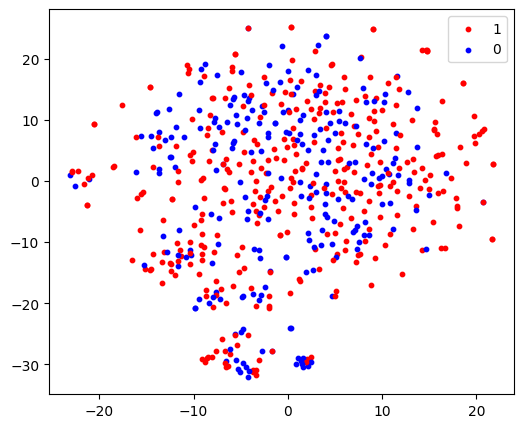

In [6]:
# represent the data in a scatter plot the are only 2 clusters the colors must be red for 0 and blue for 1
colors = ['red', 'blue']
plt.figure(figsize=(6, 5))
for i in range(len(X_2d)):
    plt.scatter(X_2d[i, 0], X_2d[i, 1], color=colors[dataset_train['label'][i]], s=10)
# add legend
plt.legend(['1', '0'], loc='upper right')
plt.show()

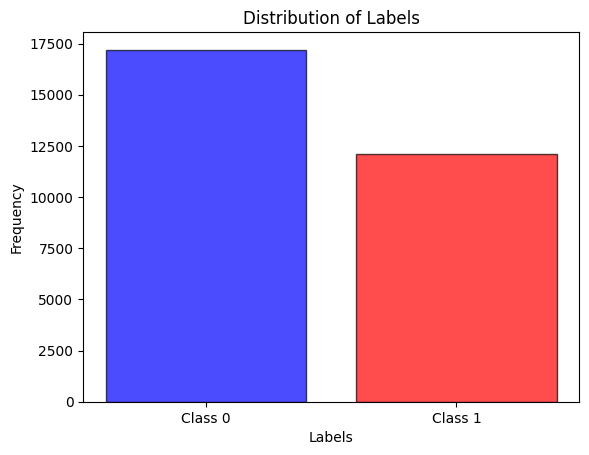

In [30]:
# Count the occurrences of each label
label_counts = dataset_train['label'].value_counts()

# Plot the histogram manually to assign colors per label
plt.bar(label_counts.index, label_counts.values, color=['blue', 'red'], alpha=0.7, edgecolor='black')

# Adding labels, legend, and title
plt.title("Distribution of Labels")
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.xticks([0, 1], ['Class 0', 'Class 1'])
#plt.legend(['Class 0', 'Class 1'], loc="upper right")

# Show the plot
plt.show()

## CLF

In [31]:
from lazypredict.Supervised import LazyClassifier

In [32]:
X_train = np.array(dataset_train["sample"].to_list())
# get subset of the data using shuffle
X_train = X_train[:1000]
y_train = np.array(dataset_train["label"].to_list())
y_train = y_train[:1000]
X_test = np.array(dataset_test["sample"].to_list())
y_test = np.array(dataset_test["label"].to_list())

In [33]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

 97%|█████████▋| 30/31 [00:29<00:00,  1.96it/s]

[LightGBM] [Info] Number of positive: 434, number of negative: 566
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.434000 -> initscore=-0.265550
[LightGBM] [Info] Start training from score -0.265550


100%|██████████| 31/31 [00:29<00:00,  1.03it/s]


In [34]:
print(models)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
SVC                                0.63               0.62     0.62      0.62   
NuSVC                              0.62               0.62     0.62      0.62   
LGBMClassifier                     0.62               0.61     0.61      0.61   
GaussianNB                         0.59               0.60     0.60      0.59   
RandomForestClassifier             0.62               0.60     0.60      0.60   
ExtraTreesClassifier               0.61               0.60     0.60      0.60   
XGBClassifier                      0.60               0.59     0.59      0.59   
AdaBoostClassifier                 0.58               0.57     0.57      0.58   
BaggingClassifier                  0.59               0.57     0.57      0.57   
LogisticRegression                 0.57               0.57     0.57      0.57   
PassiveAggressiveClassifier 

In [35]:
print(predictions)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
SVC                                0.63               0.62     0.62      0.62   
NuSVC                              0.62               0.62     0.62      0.62   
LGBMClassifier                     0.62               0.61     0.61      0.61   
GaussianNB                         0.59               0.60     0.60      0.59   
RandomForestClassifier             0.62               0.60     0.60      0.60   
ExtraTreesClassifier               0.61               0.60     0.60      0.60   
XGBClassifier                      0.60               0.59     0.59      0.59   
AdaBoostClassifier                 0.58               0.57     0.57      0.58   
BaggingClassifier                  0.59               0.57     0.57      0.57   
LogisticRegression                 0.57               0.57     0.57      0.57   
PassiveAggressiveClassifier 

# Optimzed clf

In [37]:
X_train = np.array(dataset_train["sample"].to_list())
y_train = np.array(dataset_train["label"].to_list())
X_test = np.array(dataset_test["sample"].to_list())
y_test = np.array(dataset_test["label"].to_list())

In [36]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import NuSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
import joblib  # Para guardar los modelos

# Definición de modelos y sus respectivos hiperparámetros
models = {
    "RandomForest": (RandomForestClassifier(), {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False]
    }),
}

# Diccionario para guardar los mejores modelos
best_models = {}

# Optimización y evaluación
for model_name, (model, param_grid) in models.items():
    print(f"\nOptimizing {model_name}...")
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Mejores hiperparámetros
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    
    # Evaluación en conjunto de prueba
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    print(f"Classification report for {model_name}:\n{classification_report(y_test, y_pred)}")
    
    # Guardar el mejor modelo en el diccionario
    best_models[model_name] = best_model


Optimizing RandomForest...


In [ ]:
# Guardar el mejor modelo en un archivo (ejemplo con NuSVC)
model_to_save = "NuSVC"  # Cambiar por "SVC" o "GaussianNB" si se prefiere otro
if model_to_save in best_models:
    joblib.dump(best_models[model_to_save], f"{model_to_save}_best_model.pkl")
    print(f"Modelo {model_to_save} guardado como {model_to_save}_best_model.pkl")
else:
    print(f"No se encontró el modelo {model_to_save} en el diccionario.")
